In this notebook we will work on creating ouput for our routes.

In [1]:
import osmnx as ox
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib inline

In [2]:
###OSHAWA/WHITBY 
north = 43.984503
west = -78.821660
south = 43.862879
east = -78.954552

In [3]:
# Downloading the map as a graph object 
G = ox.graph_from_bbox(north, south, east, west, network_type = 'drive') 
# Plotting the map graph 
#ox.plot_graph(G, bgcolor='white', edge_color='blue', node_color='red')

### Creating a Route

In [4]:
start_point = (43.902926, -78.949285)
end_point = (43.944515, -78.895384)

In [5]:
# Get the nearest nodes to the locations 
start_node = ox.get_nearest_node(G, start_point) 
end_node = ox.get_nearest_node(G, end_point)

In [13]:
start_node

1077969015

In [19]:
end_node

2765873189

In [6]:
# Generate the optimal path
route = nx.shortest_path(G, start_node, end_node, weight='length')

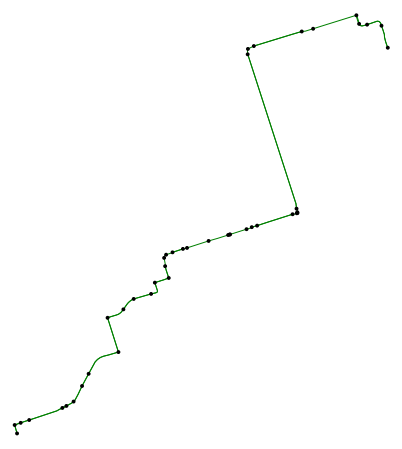

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [7]:
# Plot as a subgraph of the original graph
route_graph = G.subgraph(route)
ox.plot_graph(route_graph, bgcolor='white', edge_color='green', node_color='black')

### Getting Route Information

Here we want to get the information for each leg of this route - the street names, road types, and segment lengths.

In [47]:
route_info = list()
num_steps = len(route)
i = 0
j = 1
# We want to get the information for every step in the route
# We handle if any information is unlisted or unknown
while j < num_steps:
    step_info = list()
    step_info.append(route[i])
    try:
        name = G[route[i]][route[j]][0]['name']
        # Sometimes a street may change names within a segment - for example, switching
        # from west to east.  In these cases we will just take the first name.
        if type(name) == list:
            name = name[0]
    except KeyError:
        name = 'Unnamed'
    step_info.append(name)
    try:
        street_type = G[route[i]][route[j]][0]['highway']
    except KeyError:
        street_type = 'Unknown'
    step_info.append(street_type)
    try:
        seg_len = G[route[i]][route[j]][0]['length']
    except KeyError:
        seg_len = 'Unknown'
    step_info.append(seg_len)
    
    step_info.append(route[j])
    
    
    route_info.append(step_info)
    

    
    i +=1
    j +=1

In [48]:
# Create a data frame of this information
columns = ['Start Node', 'Street Name', 'Type', 'Length','End Node']
route_info = pd.DataFrame(route_info, columns=columns)

In [49]:
route_info

,Start Node,Street Name,Type,Length,End Node
0,1077969015,Vanier Street,residential,102.860,1050936067
1,1050936067,Dryden Boulevard,tertiary,75.001,1077968886
2,1077968886,Dryden Boulevard,tertiary,105.546,392178970
3,392178970,Dryden Boulevard,tertiary,415.333,394454438
4,394454438,Dryden Boulevard,tertiary,54.488,392167544
5,392167544,Dryden Boulevard,tertiary,98.928,392168518
6,392168518,Dryden Boulevard,tertiary,209.158,392180372
7,392180372,Dryden Boulevard,tertiary,162.799,392168202
8,392168202,Dryden Boulevard,tertiary,461.449,392172596
9,392172596,Anderson Street,tertiary,422.297,1050800983


#### Handling Unnamed Streets 

In [50]:
# Get these rows
unnamed_rows = route_info.index[route_info['Street Name'] == 'Unnamed'].tolist()

In [51]:
# For these rows we will take the length of the segment and add it to the preceeding segment
for row in unnamed_rows:
    route_info['Length'][row-1] += route_info['Length'][row]

<ipython-input-51-34c0ed0bba0d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  route_info['Length'][row-1] += route_info['Length'][row]


In [52]:
# Now drop the unnamed rows
route_info.drop(unnamed_rows, inplace=True)
# Reset the index
route_info.reset_index().drop('index', axis=1)

,Start Node,Street Name,Type,Length,End Node
0,1077969015,Vanier Street,residential,102.860,1050936067
1,1050936067,Dryden Boulevard,tertiary,75.001,1077968886
2,1077968886,Dryden Boulevard,tertiary,105.546,392178970
3,392178970,Dryden Boulevard,tertiary,415.333,394454438
4,394454438,Dryden Boulevard,tertiary,54.488,392167544
5,392167544,Dryden Boulevard,tertiary,98.928,392168518
6,392168518,Dryden Boulevard,tertiary,209.158,392180372
7,392180372,Dryden Boulevard,tertiary,162.799,392168202
8,392168202,Dryden Boulevard,tertiary,461.449,392172596
9,392172596,Anderson Street,tertiary,422.297,1050800983


#### Combining Segments that are on the Same Street

In [61]:
# Group by Street Name and sum all of the lengths for that street
simplified_route = pd.DataFrame(route_info.groupby(['Street Name', 'Type'], sort=False)['Length'].aggregate(np.sum))
# Reset the index
simplified_route = simplified_route.reset_index(level=[0,1])

In [62]:
simplified_route

,Street Name,Type,Length
0,Vanier Street,residential,102.860
1,Dryden Boulevard,tertiary,1582.702
2,Anderson Street,tertiary,422.297
3,Darren Avenue,residential,967.813
4,Thickson Road,secondary,290.270
5,Taunton Road East,secondary,1124.738
6,Taunton Road West,secondary,496.441
7,Thornton Road North,secondary,9.856
8,Thornton Road North,tertiary,2010.646
9,Conlin Road West,tertiary,1334.515


This is the output we want.  We have the total lengths now along each road in the route.

#### Adding Speeds

We see the road types listed here.  First, we will find all possible road types.

In [174]:
roads = []
# Get the road type for each edge in the graph
for g in G.edges:
    roads.append(G.edges[g]['highway'])

We have a list of lists.  We want to convert it to a single list so that we can get the unique elements.

In [175]:
roads_list = []
for road in roads:
    # As before, a road may change type if it changes speed limits for certain portions.
    if type(road) == list:
        roads_list.append(road[0])
    else:
        roads_list.append(road)
# Get the unique road types
roads_list = set(roads_list)

In [176]:
roads_list

{'motorway',
 'motorway_link',
 'residential',
 'secondary',
 'secondary_link',
 'tertiary',
 'tertiary_link',
 'unclassified'}

The types containing "link" are the ones for which we do not have names, and these are removed already.  For now we will generalize the speeds according to the following function.

In [177]:
def road_speed(road_type):
    if road_type == 'residential':
        speed = 50 
    elif road_type == 'tertiary':
        speed = 60
    elif road_type == 'secondary':
        speed = 80
    elif road_type == 'motorway':
        speed = 100
    else:
        speed = 'Unknown'
    return speed

We now apply this function and create a new column on our data frame.

In [178]:
simplified_route['Speed'] = simplified_route['Type'].apply(lambda row: road_speed(row))

In [179]:
simplified_route

,Street Name,Type,Length,Speed
0,Vanier Street,residential,102.860,50
1,Dryden Boulevard,tertiary,1582.702,60
2,Anderson Street,tertiary,422.297,60
3,Darren Avenue,residential,967.813,50
4,Thickson Road,secondary,290.270,80
5,Taunton Road East,secondary,1562.178,80
6,Taunton Road West,secondary,59.001,80
7,Thornton Road North,secondary,9.856,80
8,Thornton Road North,tertiary,2010.646,60
9,Conlin Road West,tertiary,1334.515,60


### Using Plotly to Visualize the Route

For each graph node we can retrieve its longitude and latitude values.

In [180]:
G.nodes[start_node]

{'y': 43.90302, 'x': -78.94934, 'street_count': 3}

For each node in the route, we will get these values to be used for plotting.

In [181]:
# Get the coordinates of each of the nodes
long = [] 
lat = []  
for i in route:
    point = G.nodes[i]
    long.append(point['x'])
    lat.append(point['y'])

We now use Plotply to plot the route as an interactive map.

In [188]:
def plot_path(lat, long, origin_point, destination_point):
    # Adding the route path in blue
    fig = go.Figure(go.Scattermapbox(
        name = "Route",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'blue')))
    
    # Adding the starting location in red
    fig.add_trace(go.Scattermapbox(
        name = "Start",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
     
    # Adding the ending location in green
    fig.add_trace(go.Scattermapbox(
        name = "End",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    
    # Getting the centre of the plot 
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    
    # Defining the layout
    fig.update_layout(mapbox_style="stamen-terrain",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                      mapbox = {
                          'center': {'lat': lat_center, 
                          'lon': long_center},
                          'zoom': 12})
    fig.show()

In [189]:
# Plot our path
plot_path(lat, long, start_point, end_point)

### Itemizing the Route

In [191]:
for ind in simplified_route.index:
    print('{} for {:.2f} metres at speed {} km/h.'.format(simplified_route['Street Name'][ind], 
                                                      simplified_route['Length'][ind],
                                                     simplified_route['Speed'][ind]))

Vanier Street for 102.86 metres at speed 50 km/h.
Dryden Boulevard for 1582.70 metres at speed 60 km/h.
Anderson Street for 422.30 metres at speed 60 km/h.
Darren Avenue for 967.81 metres at speed 50 km/h.
Thickson Road for 290.27 metres at speed 80 km/h.
Taunton Road East for 1562.18 metres at speed 80 km/h.
Taunton Road West for 59.00 metres at speed 80 km/h.
Thornton Road North for 9.86 metres at speed 80 km/h.
Thornton Road North for 2010.65 metres at speed 60 km/h.
Conlin Road West for 1334.51 metres at speed 60 km/h.
Founders Drive for 689.77 metres at speed 50 km/h.
